# Projeto 3: Libras em vídeo

## **Etapa 1 - Importando as bibliotecas**

In [1]:
import time
import sys
import cv2  # Open Cv
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.colab.patches import cv2_imshow

cv2.__version__

'4.1.2'

## **Etapa 2 - Conectando com o Drive**




In [2]:
from google.colab import drive # acesso ao google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pose_path = "/content/drive/My Drive/pose.zip" # carregar os classificadores modelo COCO
zip_object = zipfile.ZipFile(file=pose_path, mode="r")
zip_object.extractall("./")

In [4]:
imagens_path = "/content/drive/My Drive/imagens.zip" # carregar as imagens
zip_object = zipfile.ZipFile(file=imagens_path, mode="r")
zip_object.extractall("./")

In [5]:
modulos_path = "/content/drive/My Drive/modulos.zip" # carregar os modulos auxiliares
zip_object = zipfile.ZipFile(file=modulos_path, mode="r")
zip_object.extractall("./")
zip_object.close()

## Etapa 3 - Importando o módulo do Drive


In [6]:
sys.path.append('/content/modulos/')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/modulos/']

In [7]:
import extrator_POSICAO as posicao # retorna se o dedo esta esticado ou esta dobrado
import extrator_ALTURA as altura # retorna se um dedo esta abaixo do outro
import extrator_PROXIMIDADE as proximidade # retorna a distancia entre os dedos
import alfabeto #indica como identificar cada letra

## **Etapa 4 - Carregando o modelo e estruturas da rede neural pré-treinada**

In [8]:
# Carregando o modelo treinado e estrutura da rede neural
arquivo_proto = "/content/pose/hand/pose_deploy.prototxt"
arquivo_pesos = "/content/pose/hand/pose_iter_102000.caffemodel"
numero_pontos = 22 # 22 pontos chave da mao

# Faz a ligacao de um ponto com o outro para fazer o esqueleto
pares_pose = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], 
              [0, 9], [9, 10], [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], 
              [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

In [9]:
# definindo o alfabeto a ser trabalhado
letras = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 
          'Q', 'R', 'S', 'T', 'U', 'V', 'W']

## **Etapa 5 - Ler o modelo carregado na Etapa 4**


In [10]:
# Carregar modelo ja treinado (Rede Neural)
modelo = cv2.dnn.readNetFromCaffe(arquivo_proto, arquivo_pesos) 

In [11]:
# Cores dos pontos e da linha do esqueleto

cor_pontoA, cor_pontoB, cor_linha = (14, 201, 255), (255, 0, 128), (192, 192, 192)
cor_txtponto, cor_txtinicial, cor_txtandamento = (10, 216, 245), (255, 0, 128), (192, 192, 192)

tamanho_fonte, tamanho_linha, tamanho_circulo, espessura = 1, 1, 4, 2
fonte = cv2.FONT_HERSHEY_SIMPLEX

## **Etapa 6 - Carregando um video do Drive**

In [12]:
# Carregamento do video a ser trabalhado
video = "/content/imagens/hand/Libras/libras_4.mp4"
captura = cv2.VideoCapture(video)
ret, frame = captura.read()
ret

True

In [13]:
# definir a proporcao do frame
imagem_largura = frame.shape[1]
imagem_altura = frame.shape[0]
proporsao = imagem_largura / imagem_altura

In [14]:
# Visualizar dimensoes do frame
imagem_largura, imagem_altura, proporsao

(808, 1080, 0.7481481481481481)

## **Etapa 7 - Definir as dimensões da imagem de entrada.**





In [15]:
# definir as dimensoes da imagem de entrada
entrada_altura = 368
entrada_largura = int(((proporsao * entrada_altura) * 8) // 8)
entrada_largura, entrada_altura
# utilizamos essa proporcao para a imagem(frame) nao perder
# suas caracteristicas (largura e altura) em proporcao
# e para que ela fique mais pequena para que o processamento
# seja mais rapido

(275, 368)

## Etapa 8 - Criando a variável para salvar os resultados no Drive







In [16]:
# Criar a variavel que tem o nome do video com o resultado
resultado = './libras.avi'
gravar_video = cv2.VideoWriter(resultado, cv2.VideoWriter_fourcc(*'XVID'), 10,
                              (frame.shape[1], frame.shape[0]))

## Etapa 9 - Exibindo as saídas




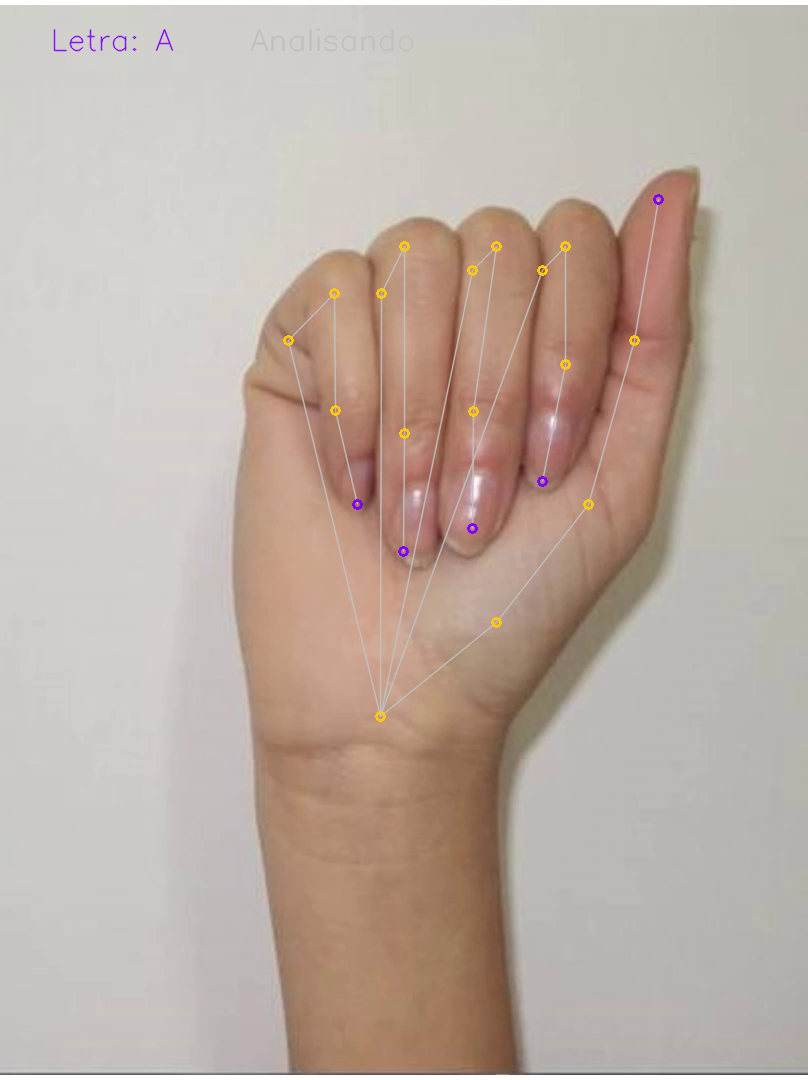

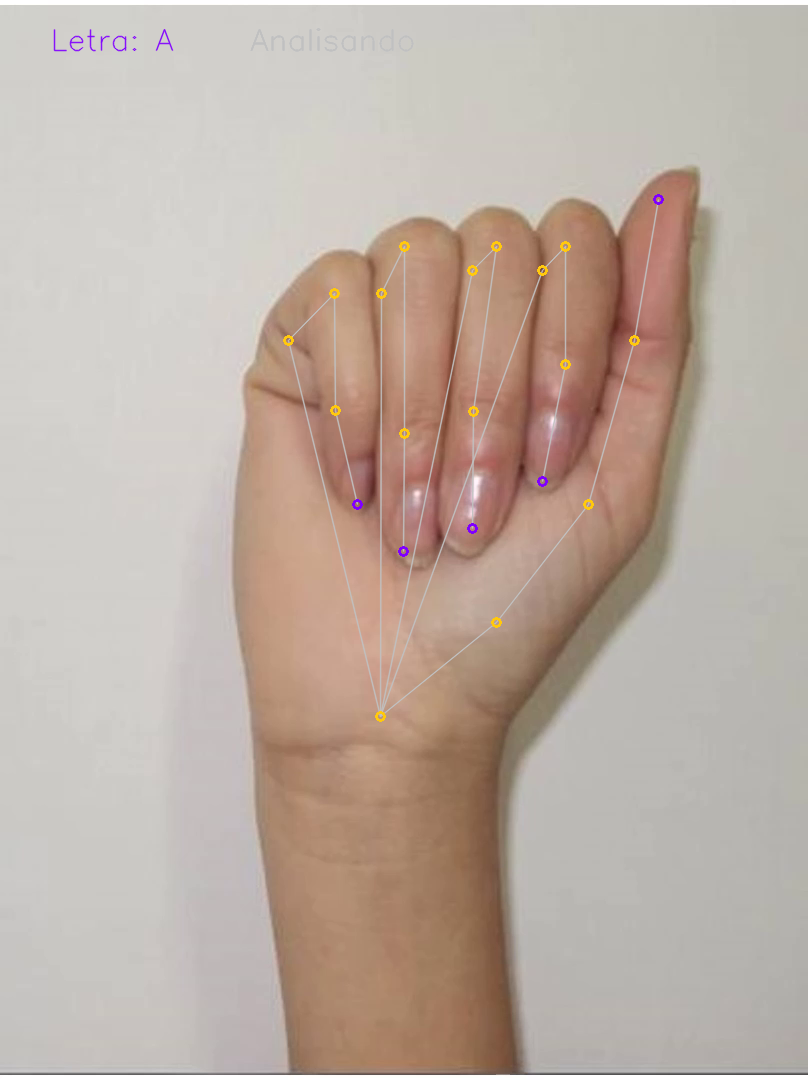

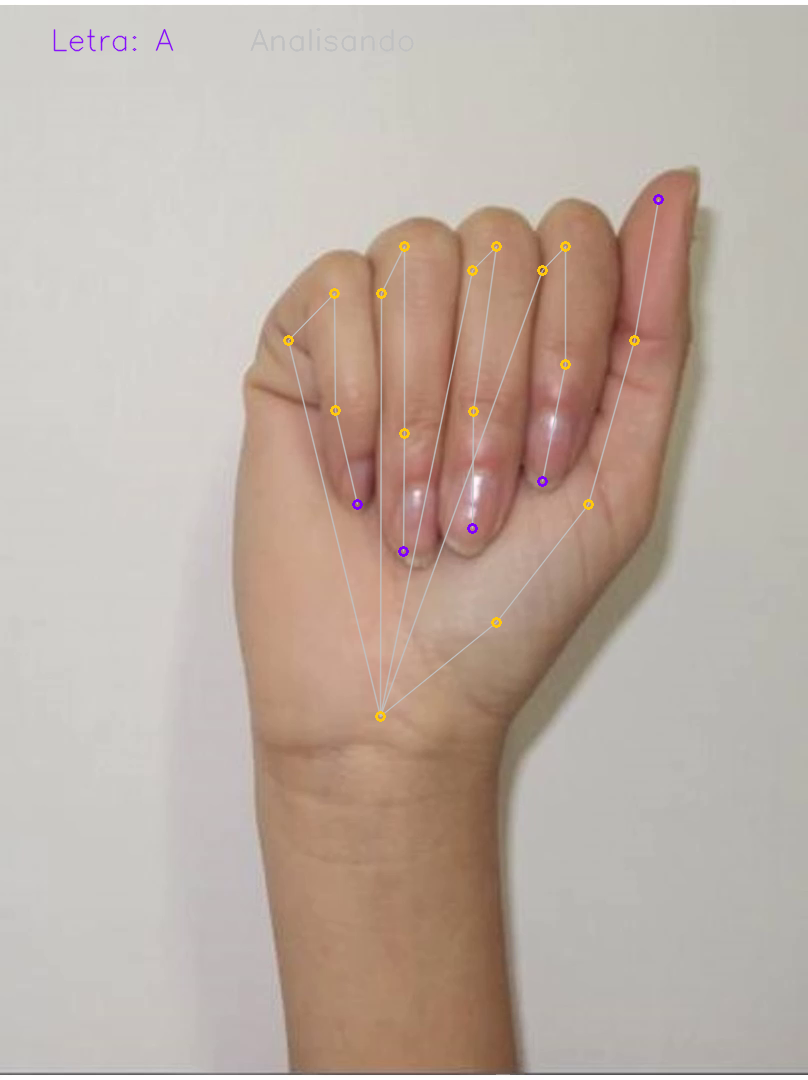

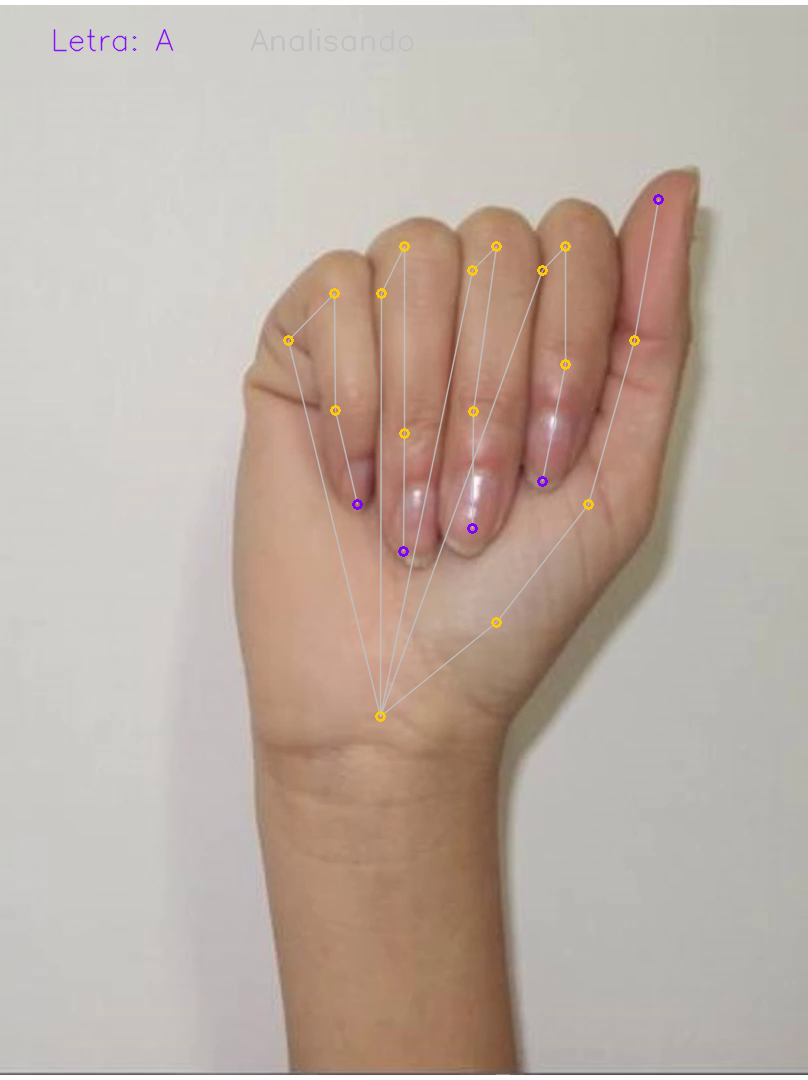

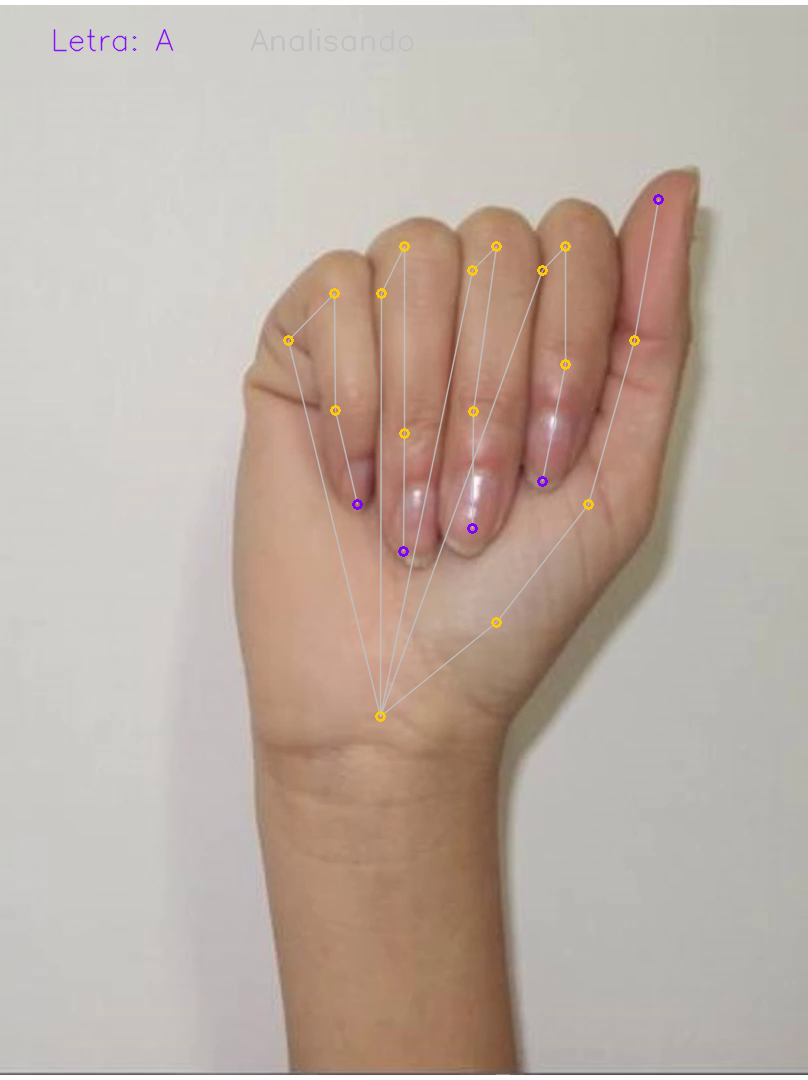

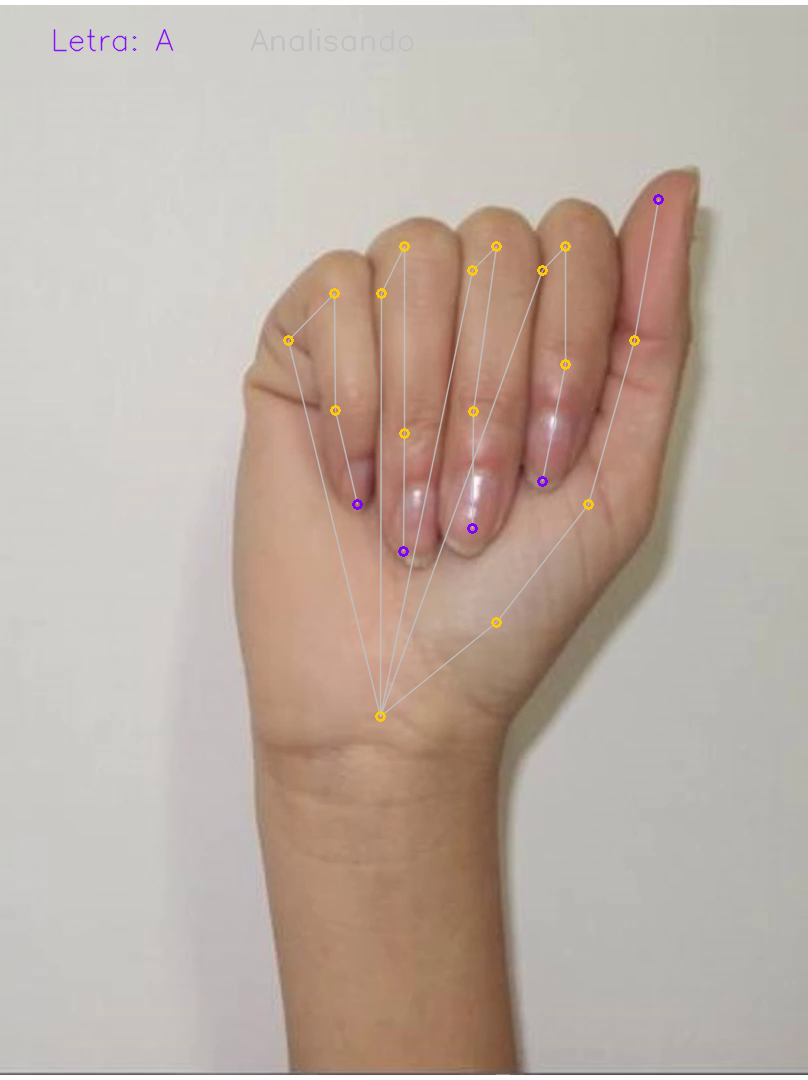

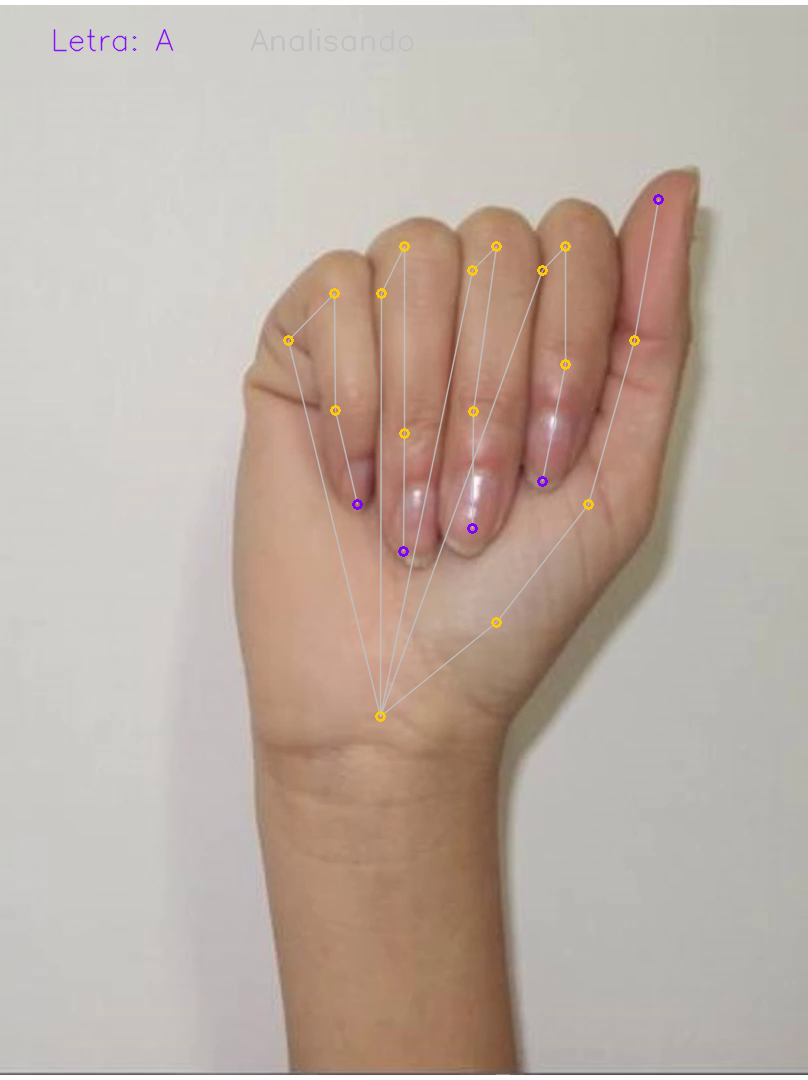

KeyboardInterrupt: ignored

In [17]:
limite = 0.1
while (cv2.waitKey(1) < 0):
    # Para cada frama
    t = time.time()
    conectado, frame = captura.read() # Le um frame
    frame_copia = np.copy(frame) # Cria uma copia do frame

    # Modificar o tamanho do frame para um processamento mais rapido
    # E aplicacoes de filtros
    tamanho = cv2.resize(frame, (imagem_largura, imagem_altura))
    mapa_suave = cv2.GaussianBlur(tamanho, (3, 3), 0, 0)
    fundo = np.uint8(mapa_suave > limite)

    if not conectado:
        cv2.waitKey()
        break

    # modificar o frame para ser uma entrada do modelo
    entrada_blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, 
                                         (entrada_largura, entrada_altura),
                                    (0, 0, 0), swapRB=False, crop=False)

    # colocar o frame no modelo
    modelo.setInput(entrada_blob)

    # receber os pontos chaves das maos na saida do modelo
    saida = modelo.forward()

    pontos = []

    # para cada ponto chave de 0 a 21 ou seja 22 pontos
    for i in range(numero_pontos):
        # Analisar o mapa de confianca e escolher o ponto com maior probabilidade
        # de estar correto
        mapa_confianca = saida[0, i, :, :]
        mapa_confianca = cv2.resize(mapa_confianca, (imagem_largura, imagem_altura))

        _, confianca, _, point = cv2.minMaxLoc(mapa_confianca)

        if confianca > limite:
            cv2.circle(frame_copia, (int(point[0]), int(point[1])), 
                       tamanho_circulo, cor_pontoA, thickness=espessura,
                       lineType=cv2.FILLED)
            cv2.putText(frame_copia, "{}".format(i), (int(point[0]), int(point[1])),
                        fonte, .8,
                        cor_txtponto, 2, lineType=cv2.LINE_AA)

            pontos.append((int(point[0]), int(point[1])))
        else:
            pontos.append((0, 0))

    # Desenhar a linha do esqueleto
    for par in pares_pose:
        parteA = par[0]
        parteB = par[1]

        if pontos[parteA] != (0, 0) and pontos[parteB] != (0, 0):
            cv2.line(frame, pontos[parteA], pontos[parteB], cor_linha, 
                     tamanho_linha, lineType=cv2.LINE_AA)
            cv2.circle(frame, pontos[parteA], tamanho_circulo, cor_pontoA,
                       thickness=espessura, lineType=cv2.FILLED)
            cv2.circle(frame, pontos[parteB], tamanho_circulo, cor_pontoB,
                       thickness=espessura, lineType=cv2.FILLED)

            cv2.line(fundo, pontos[parteA], pontos[parteB], cor_linha, 
                     tamanho_linha, lineType=cv2.LINE_AA)
            cv2.circle(fundo, pontos[parteA], tamanho_circulo, cor_pontoA, 
                       thickness=espessura, lineType=cv2.FILLED)
            cv2.circle(fundo, pontos[parteB], tamanho_circulo, cor_pontoB, 
                       thickness=espessura, lineType=cv2.FILLED)

    # Calcular a altura dos pontos e calcular sua posicao
    posicao.posicoes = []

    # dedo polegar
    posicao.verificar_posicao_DEDOS(pontos[1:5], 'polegar', altura.verificar_altura_MAO(pontos))

    # dedo indicador
    posicao.verificar_posicao_DEDOS(pontos[5:9], 'indicador', altura.verificar_altura_MAO(pontos))

    # dedo médio
    posicao.verificar_posicao_DEDOS(pontos[9:13], 'medio', altura.verificar_altura_MAO(pontos))

    # dedo anelar
    posicao.verificar_posicao_DEDOS(pontos[13:17], 'anelar', altura.verificar_altura_MAO(pontos))

    # dedo mínimo
    posicao.verificar_posicao_DEDOS(pontos[17:21], 'minimo', altura.verificar_altura_MAO(pontos))

    # por fim calcular proximidade dos pontos e verificar se o resultado eh equivalente a uma letra

    for i, a in enumerate(alfabeto.letras):
        if proximidade.verificar_proximidade_DEDOS(pontos) == alfabeto.letras[i]:
            # Se for gera o rotulo da letra
            cv2.putText(frame, 'Letra: ' + letras[i], (50, 50), fonte, 1, 
                        cor_txtinicial, tamanho_fonte,
                        lineType=cv2.LINE_AA)
        else:
            # Caso contrario coloca no topo como em Analise
            cv2.putText(frame, 'Analisando', (250, 50), fonte, 1, 
                        cor_txtandamento, tamanho_fonte,
                        lineType=cv2.LINE_AA)
    
    # Mostra a o frame analisado
    cv2_imshow(frame)

    key = cv2.waitKey(1)
    if key == 27:
        break

    #print("Tempo total = {:.2f}seg".format(time.time() - t))
    # E salva o frame no video da saida
    gravar_video.write(frame)
gravar_video.release()